In [28]:
# Notebook 2 — Logistic Regression (Unsettled vs the rest)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

transfers = pd.read_csv("../data/transfers_level.csv", parse_dates=["created_dt","funded_dt","transferred_dt"])
#transfers["created_dt_naive"] = transfers["created_dt"].dt.tz_convert(None)
#transfers = transfers.loc[transfers['created_dt_naive'] < pd.to_datetime('2024-02-01')] # Filter rows where created_dt is before February 1, 2024


# Target: 1 if UNSETTLED else 0 (per AP)
y = (transfers["status"] == "unsettled").astype(int)

# Features
transfers["created_dow"] = transfers["created_dt"].dt.dayofweek
X = transfers[["region","platform","experience","created_dow"]]

cat = ["region","platform","experience"]
num = ["created_dow"]

pre = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat), ("num", "passthrough", num)]
)

clf = Pipeline([("prep", pre), ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))

ROC-AUC: 0.7043344301673725
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      4822
           1       0.66      0.72      0.69      5946

    accuracy                           0.64     10768
   macro avg       0.64      0.63      0.63     10768
weighted avg       0.64      0.64      0.64     10768



In [29]:
# 1) Extract the fitted preprocessor and its transformers
preprocessor = clf.named_steps["prep"]
cat_transformer = preprocessor.named_transformers_["cat"]  # the OneHotEncoder
num_transformer = preprocessor.named_transformers_["num"]  # e.g. StandardScaler, passthrough, etc.

# 2) Get feature names
#   a) categorical (one‐hot) feature names
cat_features_ohe = list(cat_transformer.get_feature_names_out(cat))

#   b) numeric feature names (assumed in list `num`)
num_features = num.copy()

#   c) full feature name list must match the order in X‐matrix seen by the LR
feature_names = cat_features_ohe + num_features

# 3) Pull out the learned coefficients from the LR step
coefs = clf.named_steps["lr"].coef_[0]  # shape = (n_features,)

# 4) Build a DataFrame for easy viewing
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef":    coefs
})

# 5) Sort by strongest positive impact (or absolute value)
coef_df = coef_df.reindex(coef_df.coef.abs().sort_values(ascending=False).index)
coef_df["sign"] = np.where(coef_df["coef"] > 0, "positive", "negative")

# 6) Display top 25
coef_df.head(25)

,feature,coef,sign
0,region_Europe,0.754410,positive
6,experience_Existing,-0.687323,negative
7,experience_New,0.625711,positive
2,region_Other,-0.584070,negative
5,platform_iOS,-0.444184,negative
4,platform_Web,0.312265,positive
1,region_NorthAm,-0.231953,negative
3,platform_Android,0.070306,positive
8,created_dow,0.001919,positive


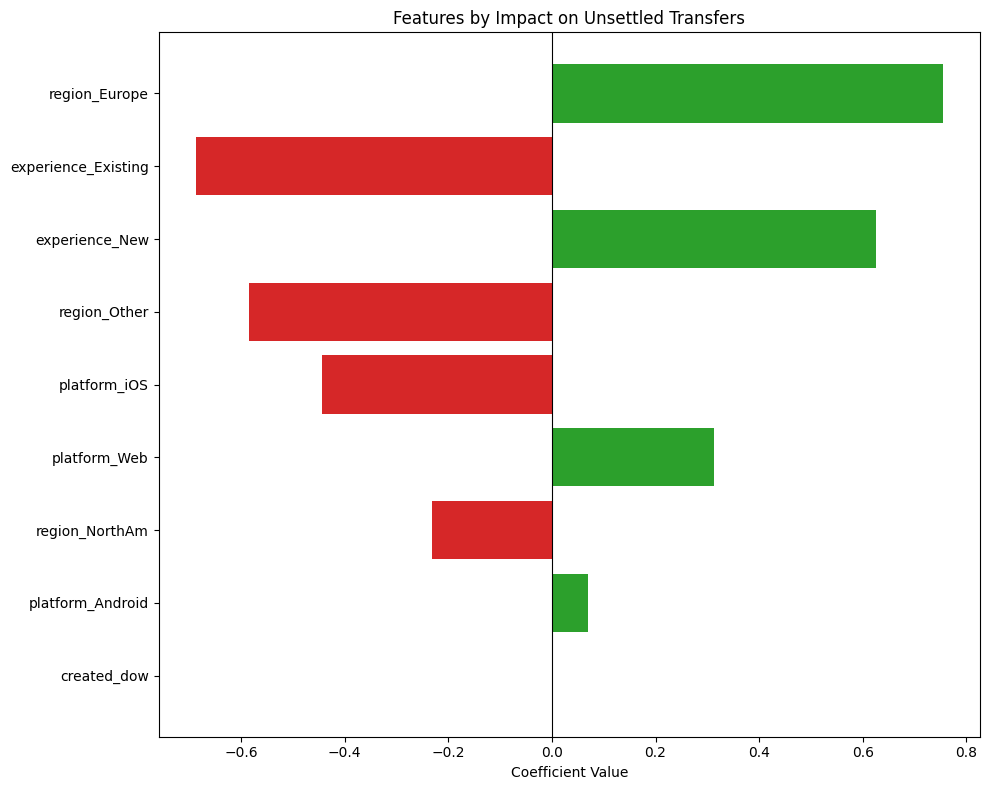

In [33]:
import matplotlib.pyplot as plt

# Select top 25 features by absolute coefficient
top_df = coef_df.copy()
top_df["abs_coef"] = top_df["coef"].abs()
top_df = top_df.sort_values("abs_coef", ascending=True).tail(25)

# 1) Compute absolute impact and sort
coef_df["abs_coef"] = coef_df["coef"].abs()
sorted_df = coef_df.sort_values("abs_coef", ascending=True).tail(25)

# 2) Color mapping: positive = green, negative = red
colors = sorted_df["coef"].apply(lambda c: "tab:green" if c > 0 else "tab:red")

# 3) Plot horizontal bar chart ordered by impact
plt.figure(figsize=(10, 8))
plt.barh(
    sorted_df["feature"],
    sorted_df["coef"],
    color=colors
)
plt.axvline(0, color="black", linewidth=0.8)
plt.xlabel("Coefficient Value")
plt.title("Features by Impact on Unsettled Transfers")
plt.tight_layout()
filename = "../exports/visualizations/Features by impact.png"
plt.savefig(filename, dpi=180)
plt.gca()  # Largest impact at top
plt.show()